In [2]:
'''
    DCGAN implementation on the MNIST dataset using Pytorch
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable

#lets us GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
'''
    DCGAN network implemented as described in the original work by
    Radford et al. 
'''
class DCGAN_Discriminator(nn.Module):

    def __init__(self, featmap_dim=16, n_channel=1):
        super(DCGAN_Discriminator, self).__init__()
        self.featmap_dim = featmap_dim
        
        '''
            need to convolve and downsample from 32x32 to 1x1, I do this in 
            4 convolutions. 3 padded convolutions reduce the image resolution 
            in half. The final 4x4 convolution has no padding and downsamples 
            the 4x4 input to a 1x1 output
        '''
        
        self.main = nn.Sequential(
                    #first pass, in dim 1 x 32 x 32
                    nn.Conv2d(1,featmap_dim,4,2,1,bias = False), 
                    nn.LeakyReLU(0.2,inplace = True), 
                    #second pass, ft.dim*2 x 16 x 16 
                    nn.Conv2d(featmap_dim,featmap_dim*2,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim*2),
                    nn.LeakyReLU(0.2,inplace = True), 
                    #third pass, ft.dim*4 x 8 x 8 
                    nn.Conv2d(featmap_dim*2,featmap_dim*4,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim*4),
                    nn.LeakyReLU(0.2,inplace = True),
                    #fourth pass, ft.dim*2 x 4 x 4 
                    nn.Conv2d(featmap_dim*4,1,4,1,0,bias = False), 
                    nn.Sigmoid() 
                    )

    def forward(self, x):
        """
        Strided convulation layers,
        Batch Normalization after convulation but not at input layer,
        LeakyReLU activation function with slope 0.2.
        """
        return self.main(x)


class DCGAN_Generator(nn.Module):

    def __init__(self, featmap_dim=16, n_channel=1, noise_dim=100):
        super(DCGAN_Generator, self).__init__()
        self.featmap_dim = featmap_dim
        
        '''
            The Generator needs to take in an input latent code and 
            upconvolve it into a 32x32 output image. This is achieved
            with upconvolutions, batchnorms, and ReLU activations
        '''
        ##first pass, project the input
        #self.project = nn.Sequential(nn.Linear(noise_dim, featmap_dim*4*4), nn.ReLU(True))
        #then perform convolutions
        self.main = nn.Sequential(
                    ##input tensor is 512 x 4 x 4 
                    nn.ConvTranspose2d(noise_dim,featmap_dim*8,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim*8), 
                    nn.ReLU(True), 
                    ##second pass, state size 256 x 8 x 8
                    nn.ConvTranspose2d(featmap_dim*8,featmap_dim*4,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim*4), 
                    nn.ReLU(True), 
                    ##third pass, state size 128 x 16 x 16
                    nn.ConvTranspose2d(featmap_dim*4,featmap_dim*2,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim*2), 
                    nn.ReLU(True), 
                    ##fourth pass, state size 1 x 32 x 32 
                    nn.ConvTranspose2d(featmap_dim*2,featmap_dim,4,2,1,bias = False), 
                    nn.BatchNorm2d(featmap_dim), 
                    nn.ReLU(True),
                    nn.ConvTranspose2d(featmap_dim,1,4,2,1,bias = False), 
                    nn.Tanh() 
                    )
    def forward(self, x):
        """
        Project noise to featureMap * width * height,
        Batch Normalization after convulation but not at output layer,
        ReLU activation function.
        """
        y = torch.reshape(x,(x.shape[0],x.shape[1],1,1))
        return self.main(y) 

def weights_init(m): 
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: 
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [43]:
#import data for MNIST 
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),transforms.Normalize(0,1)])
train_data = datasets.MNIST(
    root = 'data', 
    train = True, 
    transform =   transform,
    download = True
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform =  transform
)

batch_size = 128 

loaders = {'train': torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True,num_workers = 1, pin_memory = True), 
          'test' : torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, pin_memory = True)}


In [46]:
import time
def train_GAN(epochs, discriminator, generator, loaders,
              optimizer_D, optimizer_G, Loss_func, scheduler_D, 
              scheduler_G,noise_dim=100,batch_size = 100): 
    torch.cuda.empty_cache()
    
    total_step = len(loaders['train']) 
    
    #fixed noise for generating samples at fixed iteration
    dim_fixed_noise = 5
    
    
    for epoch in range(epochs): 
        for i , data in enumerate(loaders['train'],0): 
            #loads true images 
            real_images, _ = data
            real_images = real_images.to(device)
            #get actual batch size (dataset might not be cut evenly) 
            act_batch_size = len(real_images)
            
            
            '''
                create labels for the real and fake targets
            '''
            real_label = torch.from_numpy(np.ones(act_batch_size).astype(np.float32)).to(device)
            fake_label = torch.from_numpy(np.zeros(act_batch_size).astype(np.float32)).to(device)
            
            
            '''
            train the discriminator first
            
            '''
            discriminator.zero_grad() 
            
            #real inputs
            
            real_output =   torch.flatten(discriminator(real_images))
            real_error_D = Loss_func(real_output, real_label) 
            real_error_D.backward() 
            D_x = real_output.mean().item() #average value given to real image
            
            #fake images 
            noise = torch.randn(act_batch_size,noise_dim,device = device)
            fake_images = generator(noise)#+torch.randn(act_batch_size,1,32,32,device = device)*.
            #train discriminator on fake images        
            fake_output = torch.flatten(discriminator(fake_images))
            fake_error_D = Loss_func(fake_output, fake_label) 
            fake_error_D.backward(retain_graph =True) 
            D_G_z1 = fake_output.mean().item() 
            #total D error 
            discriminator_error = real_error_D + fake_error_D
            
            '''
                Now need to train the generator network
            '''  
            optimizer_D.step() 
            generator.zero_grad() 
            fake_output = torch.flatten(discriminator(fake_images))
            generator_error = Loss_func(fake_output,real_label) 
            generator_error.backward()
            D_G_z2 = fake_output.mean().item() 
            #update G and D
            
            
            optimizer_G.step() 


            if (i+1) % (total_step/2) == 0: 
                print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.8f}, Generator Loss: {:.8f}, Pass Rates (real/fake): {:.8f} {:.8f}' 
                       .format(epoch + 1, epochs, i + 1, total_step, discriminator_error.item(),generator_error.item(), D_x,D_G_z2))
                resize_transform = transforms.Resize(64)
                
                full_mat = np.zeros([64*dim_fixed_noise,640])
              

                for j in range(10): 
                    fixed_noise = torch.randn(dim_fixed_noise,noise_dim,device = device)
                    test_output = generator(fixed_noise)
                    test_output = resize_transform(torch.reshape(test_output,(dim_fixed_noise, 32,32)))#resize output 
                    full_mat[:,j*64:(j+1)*64] = test_output.view(dim_fixed_noise*64,64).cpu().detach().numpy()
                full_mat = np.where(full_mat>0, full_mat, 0)
                img = Image.fromarray(np.uint8(full_mat * 255) , 'L')
                print('test Image: \n')
                display(img)
        
        scheduler_D.step() 
        scheduler_G.step()
    return generator, discriminator 



Epoch [1/300], Step [469/469], Discriminator Loss: 0.39195484, Generator Loss: 0.38826239, Pass Rates (real/fake): 0.54280061 0.37830430
test Image: 



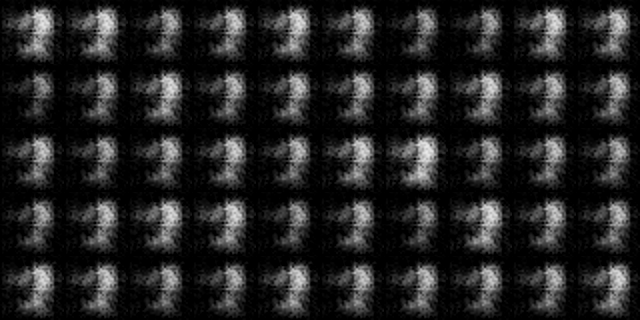

Epoch [2/300], Step [469/469], Discriminator Loss: 0.25105900, Generator Loss: 0.51168561, Pass Rates (real/fake): 0.65459406 0.28563243
test Image: 



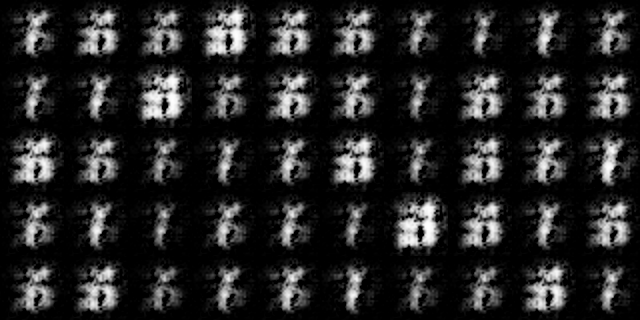

In [ ]:
from PIL import Image
torch.cuda.empty_cache()
noise_dim = 100
generator = DCGAN_Generator(noise_dim=noise_dim) 
discriminator = DCGAN_Discriminator() 
generator.cuda() 
discriminator.cuda() 

generator.apply(weights_init) 
discriminator.apply(weights_init)

loss_func = nn.MSELoss()


optimizer_D = optim.Adam(discriminator.parameters(), lr = .00005,betas=(0.5, 0.99))
optimizer_G = optim.Adam(generator.parameters(), lr = .0001,betas=(0.5, 0.99))
#optimizer_G = optim.RMSprop(gen)
#optimizer_D = optim.SGD(d_net.parameters(), lr = .1,momentum = .9, weight_decay = .0001)
#optimizer_G = optim.SGD(g_net.parameters(), lr = .1,momentum = 0, weight_decay = .0001)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size = 100, gamma=.1, verbose=False)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size = 100, gamma=.1, verbose=False)

G, D = train_GAN(300,discriminator,generator, loaders, optimizer_D, optimizer_G, loss_func,schedulerD, schedulerG,noise_dim=noise_dim,batch_size = batch_size)

In [ ]:
torch.save(G.state_dict(), 'DCGAN_gen.model') 
torch.save(D.state_dict(), 'DCGAN_dis.model')